In [9]:
import pandas as pd
import re

def parse_tcpdump_file(file_path):
    rows = []
    
    patterns = [
        # Full format with flags
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)\s+\d+\s+(\d+)\s+→\s+(\d+)\s+\[([^\]]*)\]"),
        # Without flags
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)\s+\d+\s+(\d+)\s+→\s+(\d+)"),
        # Inline port format: IP.port → IP.port
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+([^\s]+)\.(\d+)\s+→\s+([^\s]+)\.(\d+)\s+(TCP|UDP)")
    ]
    
    with open(file_path, 'r', encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.replace("â†’", "→").strip()
            matched = False
            
            for pattern in patterns:
                match = pattern.match(line)
                if match:
                    groups = match.groups()
                    
                    # Default values
                    time = src = dst = proto = src_port = dst_port = flags = None
                    
                    if len(groups) == 7:  # Full with flags
                        time, src, dst, proto, src_port, dst_port, flags = groups
                    elif len(groups) == 6:  # No flags
                        time, src, dst, proto, src_port, dst_port = groups
                        flags = ""
                    elif len(groups) == 6:  # Inline port format
                        time, src, src_port, dst, dst_port, proto = groups
                        flags = ""
                    
                    # Ensure ports are numeric
                    if not src_port.isdigit() or not dst_port.isdigit():
                        continue  # skip if port data is invalid
                    
                    # Extract optional Seq, Ack, Win, Len
                    seq = re.search(r"Seq=(\d+)", line)
                    ack = re.search(r"Ack=(\d+)", line)
                    win = re.search(r"Win=(\d+)", line)
                    length = re.search(r"Len=(\d+)", line)
                    
                    rows.append({
                        "time": float(time),
                        "src": src,
                        "dst": dst,
                        "protocol": proto,
                        "src_port": int(src_port),
                        "dst_port": int(dst_port),
                        "flags": flags,
                        "seq": int(seq.group(1)) if seq else None,
                        "ack": int(ack.group(1)) if ack else None,
                        "win": int(win.group(1)) if win else None,
                        "length": int(length.group(1)) if length else None
                    })
                    
                    matched = True
                    break
            
            # Optional: track skipped lines
            if not matched:
                pass  # could store skipped lines in a list for review
    
    return pd.DataFrame(rows)

# Example usage
df = parse_tcpdump_file("tcpdump.txt")
print(f"Parsed {len(df)} / 133 lines ({len(df)/133:.1%})")


Parsed 80 / 133 lines (60.2%)


In [15]:
import re

def detect_skipped_lines(file_path):
    skipped = []

    patterns = [
        # Full format with flags
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)\s+\d+\s+(\d+)\s+→\s+(\d+)\s+\[([^\]]*)\]"),
        # Without flags
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)\s+\d+\s+(\d+)\s+→\s+(\d+)"),
        # Inline port format: IP.port → IP.port
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+([^\s]+)\.(\d+)\s+→\s+([^\s]+)\.(\d+)\s+(TCP|UDP)")
    ]
    
    with open(file_path, 'r', encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.replace("â†’", "→").strip()
            matched = False
            
            for pattern in patterns:
                if pattern.match(line):
                    matched = True
                    break
            
            if not matched:
                skipped.append(line)

    print(f"Skipped {len(skipped)} lines:")
    for s in skipped:
        print(s)

# Run on your file
detect_skipped_lines("tcpdump.txt")


Skipped 47 lines:
8   2.886744 2600:1417:56::174c:9d09 → 2401:4900:8840:b020:556f:99ec:de73:e6dd TLSv1.2 98 Application Data
22   2.927393 2620:1ec:8f8::254 → 2401:4900:8840:b020:556f:99ec:de73:e6dd TCP 74 [TCP Keep-Alive] 443 → 53204 [ACK] Seq=1 Ack=2 Win=16388 Len=0
23   2.927422 2401:4900:8840:b020:556f:99ec:de73:e6dd → 2620:1ec:8f8::254 TCP 74 [TCP ZeroWindow] 53204 → 443 [ACK] Seq=2 Ack=2 Win=0 Len=0
33   3.906573 2401:4900:8840:b020:556f:99ec:de73:e6dd → 2603:1040:a03:9::fa TLSv1.2 124 Application Data
34   3.952488 2603:1040:a03:9::fa → 2401:4900:8840:b020:556f:99ec:de73:e6dd TLSv1.2 113 Application Data
38   4.102785  192.168.1.8 → 18.214.207.192 TLSv1.2 416 Client Hello (SNI=win-extension.femetrics.grammarly.io)
40   4.361658 18.214.207.192 → 192.168.1.8  TLSv1.2 1304 Server Hello
42   4.361812 18.214.207.192 → 192.168.1.8  TLSv1.2 599 Certificate, Server Key Exchange, Server Hello Done
45   4.364217  192.168.1.8 → 18.214.207.192 TLSv1.2 180 Client Key Exchange, Change Cipher 

In [17]:
import pandas as pd
import re

def parse_tcpdump_file(file_path):
    rows = []

    patterns = [
        # TCP/UDP with optional [TCP ...] annotation before ports and with flags
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)(?: \[[^\]]+\])?\s+\d+\s+(\d+)\s+→\s+(\d+)\s+\[([^\]]*)\]"
        ),
        # TCP/UDP with optional [TCP ...] annotation before ports and no flags
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)(?: \[[^\]]+\])?\s+\d+\s+(\d+)\s+→\s+(\d+)"
        ),
        # TLS/SSL packets with ports and flags
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TLSv\d\.\d|SSL)\s+\d+\s+(\d+)\s+→\s+(\d+)\s*(?:\[([^\]]*)\])?"
        ),
        # TLS/SSL packets without ports (just length + description)
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TLSv\d\.\d|SSL)\s+(\d+)\s+(.+)$"
        ),
    ]

    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.replace("â†’", "→").strip()
            matched = False

            for pattern in patterns:
                match = pattern.match(line)
                if match:
                    matched = True
                    groups = match.groups()

                    if pattern == patterns[0]:  # TCP/UDP with flags
                        time, src, dst, proto, src_port, dst_port, flags = groups
                        app_proto = None
                    elif pattern == patterns[1]:  # TCP/UDP without flags
                        time, src, dst, proto, src_port, dst_port = groups
                        flags = None
                        app_proto = None
                    elif pattern == patterns[2]:  # TLS/SSL with ports
                        time, src, dst, app_proto, src_port, dst_port, flags = groups
                        proto = "TCP"
                    elif pattern == patterns[3]:  # TLS/SSL without ports
                        time, src, dst, app_proto, length, desc = groups
                        proto = "TCP"
                        src_port = None
                        dst_port = None
                        flags = None

                    rows.append({
                        "time": float(time),
                        "src": src,
                        "dst": dst,
                        "protocol": proto,
                        "app_protocol": app_proto,
                        "src_port": int(src_port) if src_port else None,
                        "dst_port": int(dst_port) if dst_port else None,
                        "flags": flags,
                    })
                    break

            # If no match, skip
            if not matched:
                continue

    return pd.DataFrame(rows)


# Example usage
df = parse_tcpdump_file("tcpdump.txt")
print(f"Parsed {len(df)} / 133 lines ({len(df)/133:.1%})")
print(df.head())


Parsed 115 / 133 lines (86.5%)
       time                                      src                      dst  \
0  0.000000                             20.52.64.201              192.168.1.8   
1  2.880997                              192.168.1.8              20.42.73.31   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd  2600:1417:56::174c:9d09   
3  2.881485                              192.168.1.8           204.79.197.222   
4  2.881591                              192.168.1.8            13.107.18.254   

  protocol app_protocol  src_port  dst_port     flags  
0      TCP         None     443.0   53183.0  RST, ACK  
1      TCP         None   53202.0     443.0  FIN, ACK  
2      TCP         None   53200.0     443.0  FIN, ACK  
3      TCP         None   53208.0     443.0  FIN, ACK  
4      TCP         None   53205.0     443.0  FIN, ACK  


In [19]:
import pandas as pd
import re

def parse_tcpdump_file(file_path):
    rows = []

    patterns = [
        # TCP/UDP with optional [TCP ...] annotation before ports and with flags
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)(?: \[[^\]]+\])?\s+\d+\s+(\d+)\s+→\s+(\d+)\s+\[([^\]]*)\]"
        ),
        # TCP/UDP without flags
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)(?: \[[^\]]+\])?\s+\d+\s+(\d+)\s+→\s+(\d+)"
        ),
        # TLS/SSL with ports
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TLSv\d\.\d|SSL)\s+\d+\s+(\d+)\s+→\s+(\d+)\s*(?:\[([^\]]*)\])?"
        ),
        # TLS/SSL without ports
        re.compile(
            r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TLSv\d\.\d|SSL)\s+(\d+)\s+(.+)$"
        ),
    ]

    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.replace("â†’", "→").strip()
            matched = False

            for pattern in patterns:
                match = pattern.match(line)
                if match:
                    matched = True
                    groups = match.groups()

                    if pattern == patterns[0]:  # TCP/UDP with flags
                        time, src, dst, proto, src_port, dst_port, flags = groups
                        app_proto = None
                    elif pattern == patterns[1]:  # TCP/UDP without flags
                        time, src, dst, proto, src_port, dst_port = groups
                        flags = None
                        app_proto = None
                    elif pattern == patterns[2]:  # TLS/SSL with ports
                        time, src, dst, app_proto, src_port, dst_port, flags = groups
                        proto = "TCP"
                    elif pattern == patterns[3]:  # TLS/SSL without ports
                        time, src, dst, app_proto, length, desc = groups
                        proto = "TCP"
                        src_port = None
                        dst_port = None
                        flags = None

                    rows.append({
                        "time": float(time),
                        "src": src,
                        "dst": dst,
                        "protocol": proto,
                        "app_protocol": app_proto,
                        "src_port": int(src_port) if src_port else None,
                        "dst_port": int(dst_port) if dst_port else None,
                        "flags": flags,
                    })
                    break

            # Fallback: capture at least time, src, dst
            if not matched:
                fallback_match = re.match(
                    r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)", line
                )
                if fallback_match:
                    time, src, dst = fallback_match.groups()
                    rows.append({
                        "time": float(time),
                        "src": src,
                        "dst": dst,
                        "protocol": "OTHER",
                        "app_protocol": None,
                        "src_port": None,
                        "dst_port": None,
                        "flags": None,
                    })

    return pd.DataFrame(rows)


# Example usage
df = parse_tcpdump_file("tcpdump.txt")
print(f"Parsed {len(df)} / 133 lines ({len(df)/133:.1%})")
print(df.tail())


Parsed 133 / 133 lines (100.0%)
          time                                      src  \
128  26.791796                              192.168.1.8   
129  26.864715                            91.108.56.178   
130  26.867124                            91.108.56.178   
131  26.916633                              192.168.1.8   
132  29.071059  2401:4900:8840:b020:556f:99ec:de73:e6dd   

                        dst protocol app_protocol  src_port  dst_port flags  
128           91.108.56.178      TCP          SSL       NaN       NaN  None  
129             192.168.1.8      TCP         None     443.0   52443.0   ACK  
130             192.168.1.8      TCP          SSL       NaN       NaN  None  
131           91.108.56.178      TCP         None   52443.0     443.0   ACK  
132  2404:6800:4003:c03::bc      TCP         None   52493.0    5228.0   ACK  


In [35]:
import pandas as pd
import re

def parse_tcpdump_file(file_path):
    rows = []

    patterns = [
        # TCP/UDP with flags
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)(?: \[[^\]]+\])?\s+\d+\s+(\d+)\s+→\s+(\d+)\s+\[([^\]]*)\]"),
        # TCP/UDP without flags
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TCP|UDP)(?: \[[^\]]+\])?\s+\d+\s+(\d+)\s+→\s+(\d+)"),
        # TLS/SSL with ports
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TLSv\d\.\d|SSL)\s+\d+\s+(\d+)\s+→\s+(\d+)\s*(?:\[([^\]]*)\])?"),
        # TLS/SSL without ports
        re.compile(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)\s+(TLSv\d\.\d|SSL)\s+(\d+)\s+(.+)$"),
    ]

    with open(file_path, "r", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.replace("â†’", "→").strip()
            matched = False

            for pattern in patterns:
                match = pattern.match(line)
                if match:
                    matched = True
                    groups = match.groups()

                    if pattern == patterns[0]:  # TCP/UDP with flags
                        time, src, dst, proto, src_port, dst_port, flags = groups
                        app_proto = None
                    elif pattern == patterns[1]:  # TCP/UDP without flags
                        time, src, dst, proto, src_port, dst_port = groups
                        flags = None
                        app_proto = None
                    elif pattern == patterns[2]:  # TLS/SSL with ports
                        time, src, dst, app_proto, src_port, dst_port, flags = groups
                        proto = "TCP"
                    elif pattern == patterns[3]:  # TLS/SSL without ports
                        time, src, dst, app_proto, length, desc = groups
                        proto = "TCP"
                        src_port = None
                        dst_port = None
                        flags = None

                    rows.append({
                        "time": float(time),
                        "src": src,
                        "dst": dst,
                        "protocol": proto,
                        "app_protocol": app_proto,
                        "src_port": int(src_port) if src_port else None,
                        "dst_port": int(dst_port) if dst_port else None,
                        "flags": flags,
                        "parse_status": "full"
                    })
                    break

            # Fallback minimal parse
            if not matched:
                fallback_match = re.match(r"^\s*\d+\s+([\d\.]+)\s+(\S+)\s+→\s+(\S+)", line)
                if fallback_match:
                    time, src, dst = fallback_match.groups()
                    rows.append({
                        "time": float(time),
                        "src": src,
                        "dst": dst,
                        "protocol": "OTHER",
                        "app_protocol": None,
                        "src_port": None,
                        "dst_port": None,
                        "flags": None,
                        "parse_status": "fallback"
                    })

    df = pd.DataFrame(rows)

    # ===== FEATURE ENGINEERING =====

    # Port category encoding
    def port_category(port):
        if pd.isna(port):
            return "unknown"
        port = int(port)
        if port <= 1023:
            return "well_known"
        elif port <= 49151:
            return "registered"
        else:
            return "dynamic"

    for col in ["src_port", "dst_port"]:
        df[f"{col}_cat"] = df[col].apply(port_category)

    # Direction features (simplified: inbound/outbound/external)
    private_prefixes = ("192.168.", "10.", "172.16.")
    def is_private(ip):
        return any(ip.startswith(p) for p in private_prefixes)

    df["direction_inbound"] = df.apply(lambda r: is_private(r["dst"]) and not is_private(r["src"]), axis=1)
    df["direction_outbound"] = df.apply(lambda r: is_private(r["src"]) and not is_private(r["dst"]), axis=1)
    df["direction_external"] = ~(df["direction_inbound"] | df["direction_outbound"])

    # TCP Flag one-hot encoding
    for flag in ["ACK", "FIN", "PSH", "RST", "SYN"]:
        df[flag] = df["flags"].fillna("").str.contains(flag)

    # Time of day feature (night = 0–6 hrs)
    df["timeofday_night"] = (df["time"] % 86400 < 21600)  # assumes 'time' is seconds in capture

    return df


# Example usage
df = parse_tcpdump_file("tcpdump.txt")
print(f"Parsed {len(df)} / 133 lines ({len(df)/133:.1%})")
print(df.head(10))


Parsed 133 / 133 lines (100.0%)
       time                                      src  \
0  0.000000                             20.52.64.201   
1  2.880997                              192.168.1.8   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd   
3  2.881485                              192.168.1.8   
4  2.881591                              192.168.1.8   
5  2.881668  2401:4900:8840:b020:556f:99ec:de73:e6dd   
6  2.881759  2401:4900:8840:b020:556f:99ec:de73:e6dd   
7  2.886744                  2600:1417:56::174c:9d09   
8  2.886845  2401:4900:8840:b020:556f:99ec:de73:e6dd   
9  2.887454                  2600:1417:56::174c:9d09   

                                       dst protocol app_protocol  src_port  \
0                              192.168.1.8      TCP         None     443.0   
1                              20.42.73.31      TCP         None   53202.0   
2                  2600:1417:56::174c:9d09      TCP         None   53200.0   
3                           204.79.197.

In [37]:
import numpy as np

# Example: randomly assign 'normal' or 'malicious'
df["label"] = np.random.choice(["normal", "malicious"], size=len(df))


In [39]:
df["label"] = "normal"
df.loc[(df["SYN"]) & (~df["ACK"]), "label"] = "possible_scan"


In [41]:
df.loc[df["RST"], "label"] = "connection_reset"
df.loc[df["FIN"], "label"] = "connection_close"


In [43]:
def categorize_port(port):
    if pd.isna(port):
        return "unknown"
    if 0 <= port <= 1023:
        return "well_known"
    elif 1024 <= port <= 49151:
        return "registered"
    elif 49152 <= port <= 65535:
        return "dynamic"
    else:
        return "unknown"

df["src_port_cat"] = df["src_port"].apply(categorize_port)
df["dst_port_cat"] = df["dst_port"].apply(categorize_port)


In [45]:
df = pd.get_dummies(df, columns=["src_port_cat", "dst_port_cat"], drop_first=True)


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ===== 1. Select features =====
feature_cols = [
    "src_port", "dst_port",
    "direction_inbound", "direction_outbound", "direction_external",
    "ACK", "FIN", "PSH", "RST", "SYN",
    "timeofday_night"
]

# Add one-hot encoded columns for port categories
feature_cols += [c for c in df.columns if "src_port_cat_" in c or "dst_port_cat_" in c]

# ===== 2. Define X and y =====
X = df[feature_cols]
y = df["label"]

# ===== 3. Train-Test Split =====
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ===== 4. Train Model =====
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ===== 5. Predictions & Evaluation =====
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Classification Report:
                   precision    recall  f1-score   support

connection_close       1.00      1.00      1.00         6
connection_reset       1.00      1.00      1.00         1
          normal       1.00      1.00      1.00        19
   possible_scan       1.00      1.00      1.00         1

        accuracy                           1.00        27
       macro avg       1.00      1.00      1.00        27
    weighted avg       1.00      1.00      1.00        27


Confusion Matrix:
 [[ 6  0  0  0]
 [ 0  1  0  0]
 [ 0  0 19  0]
 [ 0  0  0  1]]


In [53]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)


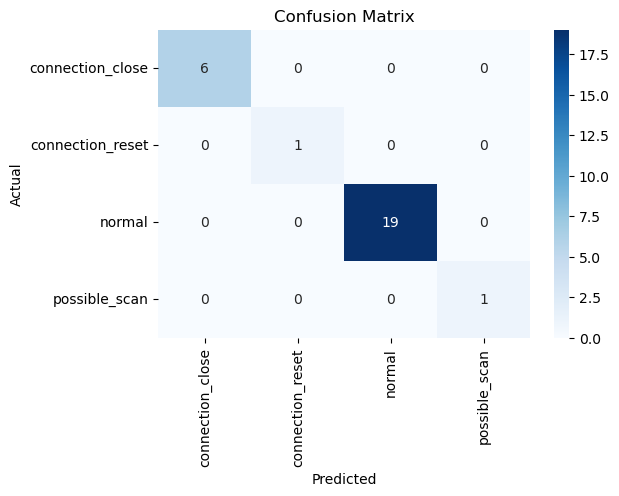

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_28176\2727693497.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, order=clf.classes_, palette="viridis")


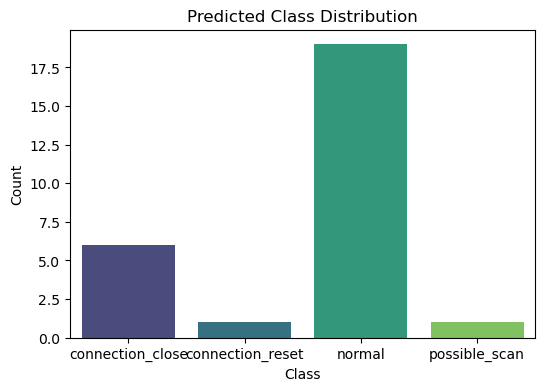

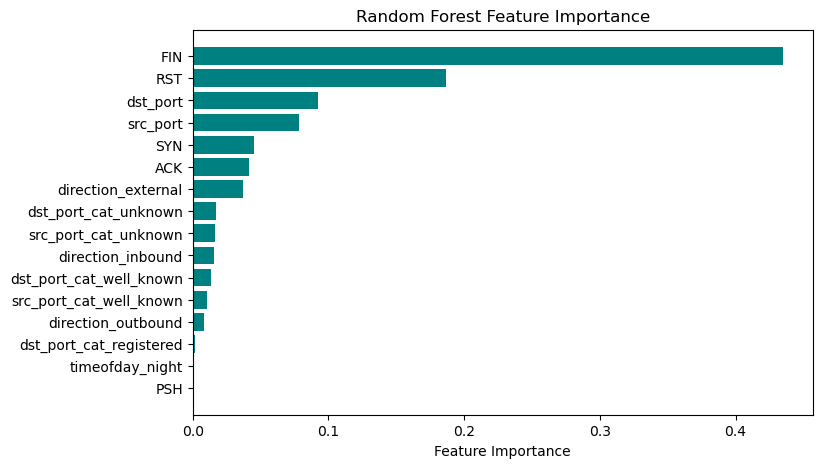

In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 🔹 1. Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🔹 2. Predicted Class Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y_pred, order=clf.classes_, palette="viridis")
plt.title("Predicted Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 🔹 3. Feature Importance
importances = clf.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

plt.figure(figsize=(8,5))
plt.barh(features[sorted_idx], importances[sorted_idx], color="teal")
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


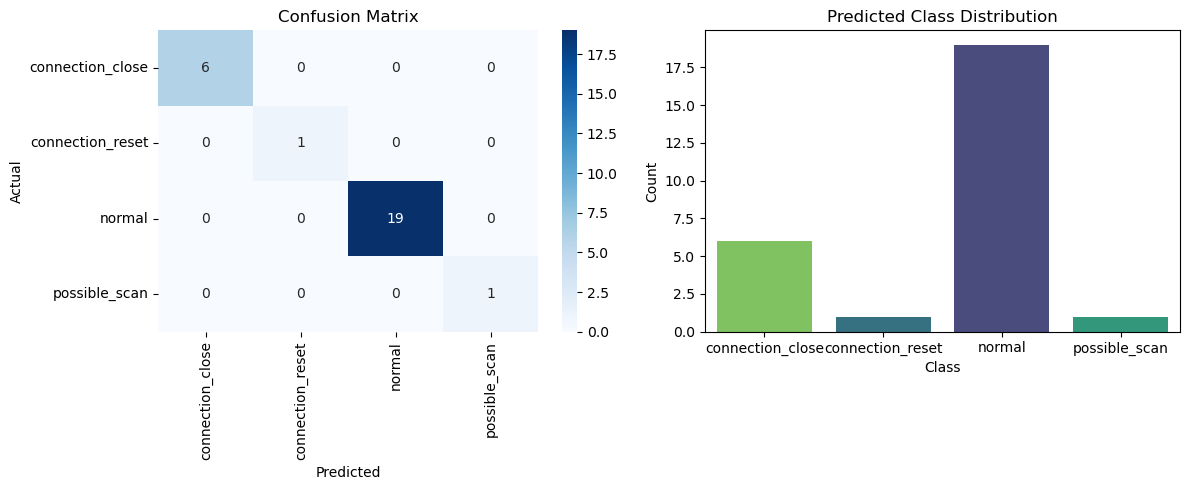

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=clf.classes_,
            yticklabels=clf.classes_,
            ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# 2️⃣ Predicted Class Distribution
sns.countplot(x=y_pred, hue=y_pred, order=clf.classes_,
              palette="viridis", legend=False, ax=axes[1])
axes[1].set_title("Predicted Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()
